# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ps_constructor
import camb
from velocileptors.LPT.lpt_rsd_fftw import LPT_RSD
from velocileptors.LPT.moment_expansion_fftw import MomentExpansion
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

# CAMB calculations 

In [2]:
z_pk = np.array([1,0.8,0.5,0.3,0.0])
ini_fn = '/Users/s2223060/Desktop/primordial_features/cosmologies/desi_params_LRG3_ELG1.ini'
pars = camb.read_ini(ini_fn)
As = pars.InitPower.As
ns = pars.InitPower.ns
k_norm = 0.05
pars.set_matter_power(redshifts=z_pk, kmax=100,k_per_logint=100);
h = pars.H0/100
results = camb.get_results(pars)
kh, z_pk, plin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=100, npoints = 2000)
fs8 = results.get_fsigma8()    
s8  = results.get_sigma8()     
fz = fs8/s8
fz = fz[::-1]
print(fz)
print(z_pk)

[0.52593127 0.68349131 0.75994384 0.83971943 0.87587239]
[0.0, 0.3, 0.5, 0.8, 1.0]


In [3]:
def PK_lin(k, As, ns, amp, freq,phi):
    return As*(k/0.05)**(ns-1)*(1 + np.sin(phi+np.log(k/0.05)*freq)*amp)

Alin = 0.05
omega_log = 80
phi = 0.5*np.pi
pars.set_initial_power_function(PK_lin, args=(As, ns,Alin, omega_log, phi))
results_feature = camb.get_results(pars)
_, _, plin_feature = results_feature.get_matter_power_spectrum(minkh=1e-4, maxkh=100, npoints = 2000)

Text(0, 0.5, '$k P(k)$')

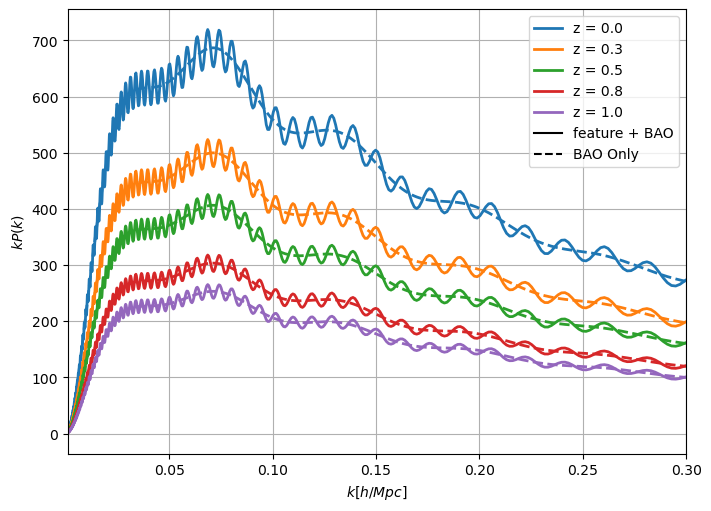

In [4]:
plt.figure(figsize = (7,5),constrained_layout=True)
for i in range(len(z_pk)):
    plt.plot(kh, kh*plin_feature[i], label = f'z = {z_pk[i]}',color = 'C'+str(i), lw = 2)
    plt.plot(kh, kh*plin[i], lw = 2,color = 'C'+str(i), ls = '--')
plt.plot([],[],color = 'black', ls = '-', label = 'feature + BAO')
plt.plot([],[],color = 'black', ls = '--', label = 'BAO Only')
plt.legend()
plt.xlim((1e-3,0.3))
plt.grid()
plt.xlabel('$ k[h/Mpc]$')
plt.ylabel('$k P(k)$')

# LPT RSD

In [5]:
k_data = np.linspace(0.02,0.2,500)

In [6]:
biases = [0.71,0.26,0.67,0.52]
stoch  = [1500.,-1900.,0]
cterms = [-3.4,-1.7,6.5,0]
LPT_pars   = biases + cterms + stoch

#biases = [1,0,0,0]
#stoch  = [0,0,0]
#cterms = [0,0,0,0]
#LPT_pars   = biases + cterms + stoch

p0_LPT = np.zeros((len(k_data),len(z_pk)))  
for i in range(len(z_pk)):
    lpt = LPT_RSD(kh,plin_feature[i],third_order=True,one_loop = True)
    lpt.make_pltable(fz[i],nmax=5,apar=1,aperp=1, kv = k_data)
    kl,p0,p2,p4 = lpt.combine_bias_terms_pkell(LPT_pars)
    p0_LPT[:,i] = p0

p0_LPT_no_feature = np.zeros((len(k_data),len(z_pk)))  
for i in range(len(z_pk)):
    lpt = LPT_RSD(kh,plin[i],third_order=True,one_loop = True)
    lpt.make_pltable(fz[i],nmax=5,apar=1,aperp=1, kv =k_data)
    kl,p0,p2,p4 = lpt.combine_bias_terms_pkell(LPT_pars)
    p0_LPT_no_feature[:,i] = p0

Text(0.5, 1.0, '$A_{\\rm log}$=0.05$\\quad\\omega_{\\rm log}$=80')

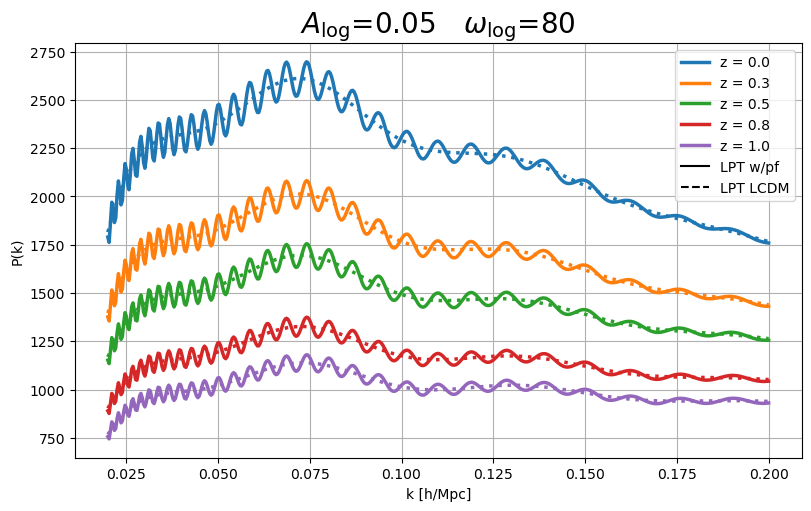

In [10]:
plt.figure(figsize = (8,5),constrained_layout=True)
for i in range(len(z_pk)):
    plt.plot(k_data, k_data*p0_LPT.T[i], label='z = %.1f' % (z_pk[i]), color = 'C'+str(i), lw = 2.5)
    plt.plot(k_data, k_data*p0_LPT_no_feature.T[i], color = 'C'+str(i), lw = 2.5, ls = ':')
    #plt.plot(K, K*plin_feature[:,i]*3.7, color = 'C'+str(i), ls = '--', lw = 2.5)
plt.plot([],[],'-', label = 'LPT w/pf',color = 'black')
plt.plot([],[],'--', label = 'LPT LCDM', color = 'black')
plt.legend()
plt.grid()
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')
plt.title(r'$A_{\rm log}$='+f'{Alin}'+r'$\quad\omega_{\rm log}$='+f'{omega_log}', fontsize = 20)

# MOME 

In [30]:
biases = [1,0,0,0.0]
cterms = [0, 0, 0, 0]
stoch  = [0, 0, 0]
MOME_pars   = [*biases, *cterms, *stoch]

p0_MOME = []
for i in range(len(z_pk)):
    mome = MomentExpansion(K,plin_feature[:,i],beyond_gauss = True, one_loop= True,
                        kmin = 0.02, kmax = 0.2, nk = 200,
                        cutoff=10, extrap_min = -4, extrap_max = 3, N = 2000, threads=1, jn=5, shear=True)

    k_mome,p0,p2,p4 = mome.compute_redshift_space_power_multipoles(MOME_pars,fz[i],reduced=True)
    p0_MOME.append(p0)
p0_MOME = np.array(p0_MOME)

p0_MOME_no_feature = []
for i in range(len(z_pk)):
    mome = MomentExpansion(K,plin_no_feature[:,i],beyond_gauss = True, one_loop= True,
                        kmin = 0.02, kmax = 0.2, nk = 200,
                        cutoff=10, extrap_min = -4, extrap_max = 3, N = 2000, threads=1, jn=5, shear=True)
    
    k_mome,p0,p2,p4 = mome.compute_redshift_space_power_multipoles(MOME_pars,fz[i],reduced=True)
    p0_MOME_no_feature.append(p0)
p0_MOME_no_feature = np.array(p0_MOME_no_feature)

In [ ]:
plt.figure(figsize = (8,5),constrained_layout=True)
for i in range(len(z_pk)):
    plt.plot(k_mome, k_mome*p0_MOME[i], label='z = %.1f' % (z_pk[i]), color = 'C'+str(i), lw = 2.5)
    plt.plot(k_mome, k_mome*p0_MOME_no_feature[i], color = 'C'+str(i), lw = 2.5, ls = ':')
    #plt.plot(K, K*plin_feature[:,i]*3.7, color = 'C'+str(i), ls = '--', lw = 2.5)
plt.xlim((1e-3,0.2))
plt.plot([],[],'-', label = 'MOME w/pf',color = 'black')
plt.plot([],[],'--', label = 'MOME LCDM', color = 'black')
plt.legend()
plt.grid()
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k)')
plt.title(r'$A_{\rm lin}$='+f'{Alin}'+r'$\quad\omega_{\rm lin}$='+f'{omega}', fontsize = 20)

# smooth 

In [28]:
def smooth(k,P, s = 0.02):
    # work in log space
    logk = np.log(k)
    logP = np.log(P)

    # build a spline with smoothing factor s
    #    s ~ N * variance_in_logP * (fractional_scale)**2
    # you’ll have to experiment:  
    #   too small → follows wiggles;  too large → washes out the broadband slope
    #s = 0.02 # start here and tweak
    spline = UnivariateSpline(logk, logP, s=s)

    # extract smooth / wiggle
    logP_smooth = spline(logk)
    P_smooth     = np.exp(logP_smooth)
    return P_smooth

In [ ]:
ps_smooth = np.column_stack([smooth(kl,p0_LPT.T[i],s=0.1) for i in range(len(z_pk))])
fig, ax = plt.subplots(2,1,figsize=(7,7), constrained_layout=True,sharex=True)

for i in range(len(z_pk)):
    ax[0].plot(kl, kl*ps_smooth[:,i], color = 'black', ls = '--', lw = 2.5)
    ax[0].plot(kl, kl*p0_LPT.T[i], label='z = %.1f' % (z_pk[i]), color = 'C'+str(i), lw = 2.5)
    #ax[0].plot(kl, kl*p0_LPT_no_feature.T[i],color = 'C'+str(i), lw = 2.5,ls = '--')
    ax[1].plot(kl, (p0_LPT.T[i]/ps_smooth[:,i]), color = 'C'+str(i), lw = 2.5) 
    ax[1].set_xlim((1e-3,0.3))
    
ax[0].legend()
ax[0].grid()
ax[1].grid()
ax[0].set_xlim((1e-2,0.5))
ax[0].set_xlabel('k [h/Mpc]')
ax[0].set_ylabel('P(k)')
ax[1].set_xlabel('k [h/Mpc]')
ax[1].set_ylabel('P(k) - P_smooth(k)')
ax[1].legend()
ax[0].set_title(r'$A_{\rm lin}$='+f'{Alin}'+r'$\quad\omega_{\rm lin}$='+f'{omega_lin}', fontsize = 15)